In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb
'''from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp'''

'from surprise import Reader, Dataset\nfrom surprise import BaselineOnly\nfrom surprise import KNNBaseline\nfrom surprise import SVD\nfrom surprise import SVDpp'

In [5]:
df = pd.read_csv('olist_processado.csv')
df.head(2)

,customer_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,product_id,price,review_id,review_score,customer_lat,customer_long,product_category_name,quantidade_item
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,88b8b52d46df026a9d1ad2136a59b30b,4,-20.500253,-47.400367,moveis_escritorio,1
1,8912fc0c3bbf1e2fbf35819e21706718,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,1,a9516a079e37a9c9c36b9b78b10169e8,112.99,7fc63200f12eebb5f387856afdd63db8,1,-2.441535,-54.720801,moveis_escritorio,2


In [37]:
df['customer_id_code'] = df.customer_id.astype('category').cat.codes
df['product_id_code'] = df.product_id.astype('category').cat.codes

In [38]:
split_value = int(len(df) * 0.80)
train_data = df[:split_value]
test_data = df[split_value:]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


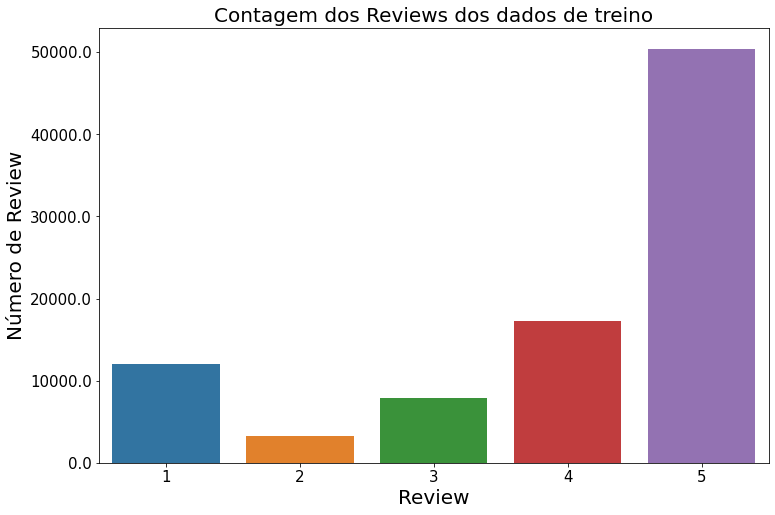

In [39]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="review_score", data=train_data)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Contagem dos Reviews dos dados de treino", fontsize = 20)
plt.xlabel("Review", fontsize = 20)
plt.ylabel("Número de Review", fontsize = 20)
plt.show()

In [40]:
no_rated_movies_per_cliente = train_data.groupby(by = "customer_id")["review_score"].count().sort_values(ascending = False)
no_rated_movies_per_cliente.head()

customer_id
f4c13379ddd0ed4f4fc1c0b49c2c5e51    22
be1c4e52bb71e0c54b11a26b8e8d59f2    22
be1b70680b9f9694d8c70f41fa3dc92b    20
d6646ea91d8cd9fc7e6882a7068779d4    20
62ff903909cb86e2b07156a6d7cc48da    18
Name: review_score, dtype: int64

In [41]:
no_ratings_per_product = train_data.groupby(by = "product_id")["review_score"].count().sort_values(ascending = False)
no_ratings_per_product.head()

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    528
99a4788cb24856965c36a24e339b6058    527
422879e10f46682990de24d770e7f83d    496
368c6c730842d78016ad823897a372db    413
389d119b48cf3043d311335e499d9c6b    399
Name: review_score, dtype: int64

In [42]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.review_score, (df.customer_id_code, df.product_id_code)))
    return sparse_data

In [43]:
train_sparse_data = get_user_item_sparse_matrix(train_data)

In [44]:
test_sparse_data = get_user_item_sparse_matrix(test_data)

In [45]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Média de Review Global: {}".format(global_average_rating))

Média de Review Global: 4.495230908168693


In [46]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

In [47]:
average_rating_user = get_average_rating(train_sparse_data, True)

In [51]:
avg_rating_product = get_average_rating(train_sparse_data, False)

In [50]:
total_users = len(np.unique(df["customer_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
                  
print("Total no. de Clientes = {}".format(total_users))
print("No. de Clientes no 'train data'= {}".format(train_users))
print("No. de Clientes não presentes no 'train data' = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. de Clientes = 97277
No. de Clientes no 'train data'= 77629
No. de Clientes não presentes no 'train data' = 19648(20.0%)


In [52]:
total_produtos = len(np.unique(df["product_id"]))
train_produtos = len(avg_rating_product)
uncommonProdutos = total_produtos - train_produtos
                  
print("Total no. de Produtos = {}".format(total_produtos))
print("No. de Produtos no 'train data' = {}".format(train_produtos))
print("No. de Clientes no 'train data' = {}({}%)".format(uncommonProdutos, np.round((uncommonProdutos/total_produtos)*100), 2))

Total no. de Produtos = 32400
No. de Produtos no 'train data' = 17364
No. de Clientes no 'train data' = 15036(46.0%)


In [55]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)
    
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr 

In [56]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

In [57]:
similar_user_matrix[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [77]:
df.head()

,customer_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,product_id,price,review_id,review_score,customer_lat,customer_long,product_category_name,quantidade_item,customer_id_code,product_id_code
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,88b8b52d46df026a9d1ad2136a59b30b,4,-20.500253,-47.400367,moveis_escritorio,1,2561,21356
1,8912fc0c3bbf1e2fbf35819e21706718,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,1,a9516a079e37a9c9c36b9b78b10169e8,112.99,7fc63200f12eebb5f387856afdd63db8,1,-2.441535,-54.720801,moveis_escritorio,2,52020,21356
2,8912fc0c3bbf1e2fbf35819e21706718,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,2,a9516a079e37a9c9c36b9b78b10169e8,112.99,7fc63200f12eebb5f387856afdd63db8,1,-2.441535,-54.720801,moveis_escritorio,2,52020,21356
3,f0ac8e5a239118859b1734e1087cbb1f,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,2017-05-07 20:11:26,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,251191809e37c1cffc16865947c18a4d,3,-29.879675,-51.272093,moveis_escritorio,1,91607,21356
4,6bc8d08963a135220ed6c6d098831f84,mage,RJ,2e604b3614664aa66867856dba7e61b7,2018-02-03 19:45:40,1,a9516a079e37a9c9c36b9b78b10169e8,106.99,f7123bac5b91a0e2e38d8b41fd1206f4,4,-22.610299,-43.176850,moveis_escritorio,1,40815,21356


In [82]:
def compute_product_similarity_count(sparse_matrix, df, product_id_code):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_products = df.loc[product_id_code][6], similarity[product_id_code].count_nonzero()
    return no_of_similar_products

In [88]:
similar_products = compute_product_similarity_count(train_sparse_data, df, 21356)
print("Produtos Similares = {}".format(similar_products))


Produtos Similares = ('11875b30b49585209e608f40e8082e65', 2)


In [85]:
df.loc[21356]

customer_id                 b71cb835be11fec9d0e0903e4d9acefe
customer_city                                      canoinhas
customer_state                                            SC
order_id                    77e30dea9bbb161e9d91918418f4aafa
order_purchase_timestamp                 2017-08-03 07:42:32
order_item_id                                              1
product_id                  11875b30b49585209e608f40e8082e65
price                                                     65
review_id                   2f7a94c9b1a0ae1ad24233743ccc6790
review_score                                               5
customer_lat                                         -26.181
customer_long                                       -50.3732
product_category_name                          esporte_lazer
quantidade_item                                            1
customer_id_code                                       69824
product_id_code                                         2268
Name: 21356, dtype: obje

In [89]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_products):
    users, products, review_score = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_products = np.unique(products)
    np.random.seed(15)
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    product = np.random.choice(uniq_products, no_of_products, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(products, products))
    sparse_matrix = sparse.csr_matrix((review_score[mask], (users[mask], products[mask])), shape = (max(user)+1, max(product)+1))
    
    return sparse_matrix

In [93]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 20, 2)

test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 20, 2)


ValueError: column index exceeds matrix dimensions